In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import get_scheduler
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn
from tqdm import tqdm

# Import preprocessing utilities - CLEAN ARCHITECTURE APPROACH
import sys
sys.path.append('../utils')

# Option 1: Import individual functions (recommended)
from preprocessing import preprocess_yelp_data, visualize_label_distribution

# Option 2: Import all preprocessing functions if needed
# from preprocessing import *

print("✅ Libraries and preprocessing utilities imported successfully!")
print("📋 Using centralized preprocessing functions from utils/preprocessing.py")

✅ Libraries and preprocessing utilities imported successfully!
📋 Using centralized preprocessing functions from utils/preprocessing.py


# Yelp Sentiment Analysis with DistilBERT - Training Pipeline

This notebook contains the complete training pipeline for sentiment analysis on Yelp reviews using DistilBERT.

## Architecture Design
- **Preprocessing Functions**: Defined inline (could be imported from utils/ in production)
- **Model Training**: Complete end-to-end training with validation
- **Best Practices**: Function-based approach for reusability and maintainability

## Workflow
1. Data Loading & Exploration
2. Data Cleaning & Preprocessing  
3. Label Encoding & Data Splitting
4. Tokenization with DistilBERT
5. Model Training with Validation
6. Model Evaluation & Testing

Starting complete preprocessing pipeline...
This uses the centralized preprocessing functions from utils/preprocessing.py
Loading data from ../data/yelp_restaurants_hotels_ver2.csv
Dataset loaded with shape: (147757, 16)
Starting data cleaning...
Removed 6 rows with missing values
Final dataset shape: (147751, 16)
Encoding sentiment labels...
Label Encoding Mapping: {'negative': 0, 'neutral': 1, 'positive': 2}
Splitting data into train/validation/test sets...
Train size: 118200 (80.0%)
Validation size: 14775 (10.0%)
Test size: 14776 (10.0%)
Dataset loaded with shape: (147757, 16)
Starting data cleaning...
Removed 6 rows with missing values
Final dataset shape: (147751, 16)
Encoding sentiment labels...
Label Encoding Mapping: {'negative': 0, 'neutral': 1, 'positive': 2}
Splitting data into train/validation/test sets...
Train size: 118200 (80.0%)
Validation size: 14775 (10.0%)
Test size: 14776 (10.0%)


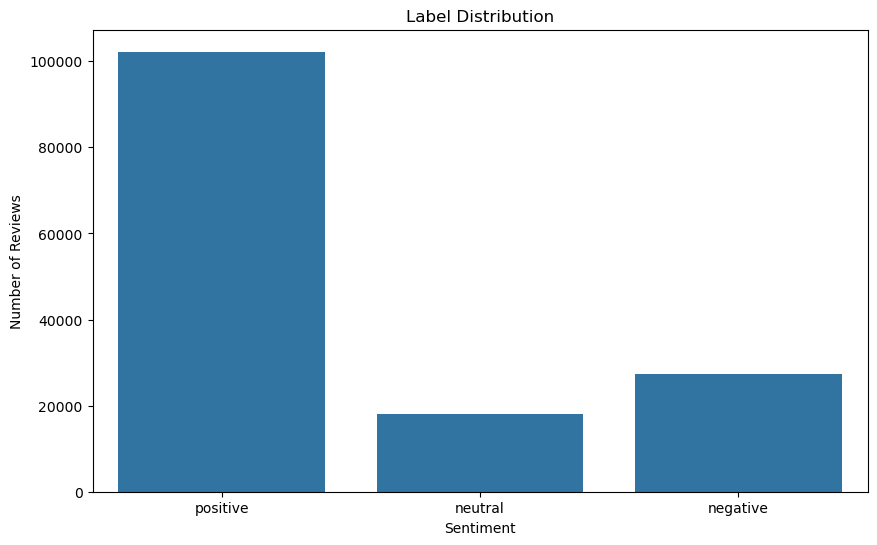


Label Distribution:
star_sentiment
positive    102220
negative     27376
neutral      18155
Name: count, dtype: int64

Percentage Distribution:
star_sentiment
positive    69.183965
negative    18.528470
neutral     12.287565
Name: proportion, dtype: float64

Data preprocessing completed!
Ready for model training with 118200 training samples


In [2]:
# Load and preprocess data using the centralized preprocessing pipeline
data_path = "../data/yelp_restaurants_hotels_ver2.csv"

print("Starting complete preprocessing pipeline...")
print("This uses the centralized preprocessing functions from utils/preprocessing.py")

# Use the complete preprocessing pipeline
train_texts, val_texts, test_texts, train_labels, val_labels, test_labels, label_encoder = preprocess_yelp_data(data_path)

print("\nData preprocessing completed!")
print(f"Ready for model training with {len(train_texts)} training samples")

## 1. Data Loading and Exploration

## 2. Data Loading and Preprocessing Pipeline

**🏗 Clean Architecture Approach:**
- Preprocessing functions are centralized in `utils/preprocessing.py`
- Training notebook imports and uses these functions
- No code duplication between notebooks
- Easy to maintain and modify preprocessing logic

In [3]:
# Cell 4

from transformers import DistilBertTokenizerFast

# Load pre-trained DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Tokenize all datasets
def tokenize_data(texts, labels, max_len=256):
    return tokenizer(
        list(texts),
        truncation=True,
        padding=True,
        max_length=max_len,
        return_tensors="pt"
    ), np.array(labels)

# Tokenize train, validation, and test sets
train_encodings, train_labels = tokenize_data(train_texts, train_labels)
val_encodings, val_labels = tokenize_data(val_texts, val_labels)
test_encodings, test_labels = tokenize_data(test_texts, test_labels)

print("Tokenization complete.")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Tokenization complete.


## 3. Text Tokenization with DistilBERT

In [4]:
# Cell 5

import torch
from torch.utils.data import Dataset

class YelpSentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Wrap datasets
train_dataset = YelpSentimentDataset(train_encodings, train_labels)
val_dataset = YelpSentimentDataset(val_encodings, val_labels)
test_dataset = YelpSentimentDataset(test_encodings, test_labels)

print("PyTorch datasets ready.")


PyTorch datasets ready.


In [5]:
# Cell 6

from torch.utils.data import DataLoader

# Set batch size
batch_size = 16

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print("DataLoaders are ready!")


DataLoaders are ready!


In [6]:
# Cell 7

from transformers import DistilBertForSequenceClassification

# Load pre-trained DistilBERT model with a classification head for 3 classes
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3  # For positive, neutral, negative
)

# Move model to GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model loaded on {device}.")


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded on mps.


In [ ]:
# Cell 8

from transformers import get_scheduler
from torch.optim import AdamW

# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

# Define learning rate scheduler
num_epochs = 4
num_training_steps = len(train_loader) * num_epochs
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

# Define evaluation metric function
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(preds, labels):
    preds = np.argmax(preds, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return acc, precision, recall, f1

In [11]:
# Cell 9

from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to tensor and move to the same device as model
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class Weights:", class_weights_tensor)

# Define weighted loss function
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)


Class Weights: tensor([1.7990, 2.7128, 0.4818], device='cuda:0')


In [12]:
# Cell 10

from tqdm import tqdm

best_f1 = 0.0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # --- Training ---
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(train_loader):
        # Move batch to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        all_preds.extend(logits.detach().cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_acc, train_prec, train_rec, train_f1 = compute_metrics(all_preds, all_labels)
    print(f"Train Loss: {total_loss:.4f} | Acc: {train_acc:.4f} | Prec: {train_prec:.4f} | Rec: {train_rec:.4f} | F1: {train_f1:.4f}")

    # --- Validation ---
    model.eval()
    val_preds = []
    val_labels_list = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            val_preds.extend(logits.detach().cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    val_acc, val_prec, val_rec, val_f1 = compute_metrics(val_preds, val_labels_list)
    print(f"Val Acc: {val_acc:.4f} | Prec: {val_prec:.4f} | Rec: {val_rec:.4f} | F1: {val_f1:.4f}")

    # Save best model
    if val_f1 > best_f1:
        torch.save(model.state_dict(), "best_distilbert_model.pt")
        best_f1 = val_f1
        print("Best model saved!")




Epoch 1/3


100%|██████████| 7388/7388 [42:43<00:00,  2.88it/s]


Train Loss: 3905.3538 | Acc: 0.8173 | Prec: 0.8619 | Rec: 0.8173 | F1: 0.8338
Val Acc: 0.8543 | Prec: 0.8828 | Rec: 0.8543 | F1: 0.8650
Best model saved!

Epoch 2/3


100%|██████████| 7388/7388 [42:47<00:00,  2.88it/s]


Train Loss: 2866.5310 | Acc: 0.8687 | Prec: 0.9003 | Rec: 0.8687 | F1: 0.8797
Val Acc: 0.8631 | Prec: 0.8889 | Rec: 0.8631 | F1: 0.8726
Best model saved!

Epoch 3/3


100%|██████████| 7388/7388 [42:48<00:00,  2.88it/s]


Train Loss: 1762.2487 | Acc: 0.9179 | Prec: 0.9355 | Rec: 0.9179 | F1: 0.9233
Val Acc: 0.8635 | Prec: 0.8852 | Rec: 0.8635 | F1: 0.8719


              precision    recall  f1-score   support

    negative       0.88      0.81      0.84      2738
     neutral       0.48      0.68      0.56      1815
    positive       0.96      0.91      0.93     10223

    accuracy                           0.86     14776
   macro avg       0.77      0.80      0.78     14776
weighted avg       0.89      0.86      0.87     14776



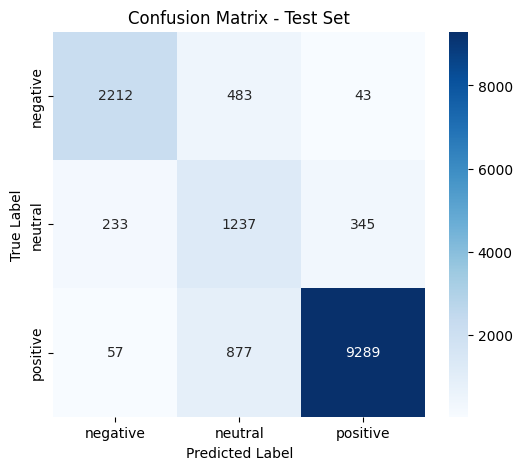

In [13]:
# Cell 11

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the best saved model (from training loop)
model.load_state_dict(torch.load("best_distilbert_model.pt"))
model.eval()

# Predict on test set
test_preds = []
test_true = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        test_preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
        test_true.extend(labels.cpu().numpy())

# Classification report
print(classification_report(test_true, test_preds, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(test_true, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set")
plt.show()
